In [22]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
import numpy as np
from tensorflow.keras.preprocessing import image
import os
import cv2
import numpy as np

In [23]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [17]:
%cd /content/drive/MyDrive/final_vimm/

/content/drive/MyDrive/final_vimm


In [ ]:
!unzip train_all.zip

In [ ]:
!unzip test_all.zip

In [18]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

1 Physical GPUs, 1 Logical GPUs


# **DATA PREPARATION**

In [ ]:
def extract_and_label_frames(videos_without_guns_path, videos_with_guns_path, labels_path, output_path, time_window=5, fps=24):
    if not os.path.exists(output_path):
        os.makedirs(output_path)

    gun_appear_dir = os.path.join(output_path, 'gun_will_appear')
    no_gun_dir = os.path.join(output_path, 'no_gun')

    if not os.path.exists(gun_appear_dir):
        os.makedirs(gun_appear_dir)

    if not os.path.exists(no_gun_dir):
        os.makedirs(no_gun_dir)

    for video_file in os.listdir(videos_without_guns_path):
        video_path = os.path.join(videos_without_guns_path, video_file)
        cap = cv2.VideoCapture(video_path)
        frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        for i in range(frame_count):
            ret, frame = cap.read()
            if not ret:
                break
            frame_path = os.path.join(no_gun_dir, f'{os.path.splitext(video_file)[0]}_frame_{i}.jpg')
            cv2.imwrite(frame_path, frame)
        cap.release()

    for video_file in os.listdir(videos_with_guns_path):
        video_path = os.path.join(videos_with_guns_path, video_file)
        label_file = os.path.join(labels_path, f'{os.path.splitext(video_file)[0]}labels.txt')

        if not os.path.exists(label_file):
            continue

        with open(label_file, 'r') as lf:
            try:
                gun_appearance_time = int(lf.readline().strip())
            except:
                continue

        gun_appearance_frame = gun_appearance_time * fps
        start_frame = max(0, gun_appearance_frame - time_window * fps)
        print(start_frame)

        cap = cv2.VideoCapture(video_path)
        cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame)
        for i in range(start_frame, min(gun_appearance_frame, int(cap.get(cv2.CAP_PROP_FRAME_COUNT)))):
            ret, frame = cap.read()
            if not ret:
                break
            frame_path = os.path.join(gun_appear_dir, f'{os.path.splitext(video_file)[0]}_frame_{i}.jpg')
            cv2.imwrite(frame_path, frame)
        cap.release()

videos_without_guns_path = 'videos_without_guns'
videos_with_guns_path = 'videos_with_guns_and_labels/videos'
labels_path = 'videos_with_guns_and_labels/labels'
output_path = 'datos_viejos2'

extract_and_label_frames(videos_without_guns_path, videos_with_guns_path, labels_path, output_path)


In [ ]:
# THIS IS FOR THE OTHER DATA PROCESSING

# import os
# import cv2

# def extract_and_label_frames(videos_without_guns_path, videos_with_guns_path, labels_file_path, output_path, time_window=5, fps=24):
#     if not os.path.exists(output_path):
#         os.makedirs(output_path)

#     gun_appear_dir = os.path.join(output_path, 'gun_will_appear')
#     no_gun_dir = os.path.join(output_path, 'no_gun')

#     if not os.path.exists(gun_appear_dir):
#         os.makedirs(gun_appear_dir)

#     if not os.path.exists(no_gun_dir):
#         os.makedirs(no_gun_dir)

#     # Parse the labels file
#     labels = {}
#     with open(labels_file_path, 'r') as lf:
#         for line in lf:
#             if line.startswith('#') or not line.strip():
#                 continue
#             video_file, time_str = line.strip().split(', ')
#             minutes, seconds = map(int, time_str.split(':'))
#             total_seconds = minutes * 60 + seconds
#             labels[video_file] = total_seconds

#     # Process videos without guns
#     for video_file in os.listdir(videos_without_guns_path):
#         video_path = os.path.join(videos_without_guns_path, video_file)
#         cap = cv2.VideoCapture(video_path)
#         frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
#         for i in range(frame_count):
#             ret, frame = cap.read()
#             if not ret:
#                 break
#             frame_path = os.path.join(no_gun_dir, f'{os.path.splitext(video_file)[0]}_frame_{i}.jpg')
#             cv2.imwrite(frame_path, frame)
#         cap.release()

#     # Process videos with guns
#     for video_file in os.listdir(videos_with_guns_path):
#         video_path = os.path.join(videos_with_guns_path, video_file)

#         if video_file not in labels:
#             continue

#         gun_appearance_time = labels[video_file]
#         gun_appearance_frame = gun_appearance_time * fps
#         start_frame = max(0, gun_appearance_frame - time_window * fps)

#         cap = cv2.VideoCapture(video_path)
#         cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame)
#         for i in range(start_frame, min(gun_appearance_frame, int(cap.get(cv2.CAP_PROP_FRAME_COUNT)))):
#             ret, frame = cap.read()
#             if not ret:
#                 break
#             frame_path = os.path.join(gun_appear_dir, f'{os.path.splitext(video_file)[0]}_frame_{i}.jpg')
#             cv2.imwrite(frame_path, frame)
#         cap.release()

# videos_without_guns_path = 'empty_folder'
# videos_with_guns_path = 'dataset_part_2/Videos'
# labels_path = 'dataset_part_2/Labels/labels.txt'
# output_path = 'gun_videos_part_2'

# extract_and_label_frames(videos_without_guns_path, videos_with_guns_path, labels_path, output_path)


## Baseline Model ##

In [ ]:
base_path = '/content/drive/MyDrive/final_vimm/'

In [ ]:
gun_will_appear_path = 'datos_viejos2/gun_will_appear'
no_gun_path = 'datos_viejos2/no_gun'

In [ ]:
no_gun_videos = list(set([f.split('_')[0] for f in os.listdir(no_gun_path)]))
gun_videos = list(set([f.split('_')[0] for f in os.listdir(gun_will_appear_path)]))

In [ ]:
no_gun_videos

['1', '7', '2', '6', '8', '10', '5', '9', '4', '3']

In [ ]:
gun_videos

[]

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
train_gun, test_gun = train_test_split(gun_videos, test_size=0.2, random_state=42)

In [ ]:
train_no_gun, test_no_gun = train_test_split(no_gun_videos, test_size=0.2, random_state=42)

In [ ]:
import shutil

In [ ]:
def copy_files(video_list, source_path, destination_path):
    if not os.path.exists(destination_path):
        os.makedirs(destination_path)
    for video in video_list:
        for file in os.listdir(source_path):
            if file.startswith(video):
                shutil.copy(os.path.join(source_path, file), destination_path)

In [ ]:
train_path = os.path.join(base_path, 'train4')
test_path = os.path.join(base_path, 'test4')

In [ ]:
copy_files(train_no_gun, no_gun_path, os.path.join(train_path, 'no_gun'))
copy_files(test_no_gun, no_gun_path, os.path.join(test_path, 'no_gun'))
copy_files(train_gun, gun_will_appear_path, os.path.join('train4', 'gun_will_appear'))
copy_files(test_gun, gun_will_appear_path, os.path.join('test4', 'gun_will_appear'))

In [ ]:
train_source_dirs = ['train2', 'train4']
test_source_dirs = ['test2', 'test4']

train_target_dir = 'train_all'
test_target_dir = 'test_all'

os.makedirs(os.path.join(train_target_dir, 'no_gun'), exist_ok=True)
os.makedirs(os.path.join(train_target_dir, 'gun_will_appear'), exist_ok=True)
os.makedirs(os.path.join(test_target_dir, 'no_gun'), exist_ok=True)
os.makedirs(os.path.join(test_target_dir, 'gun_will_appear'), exist_ok=True)

def move_files(source_dirs, target_dir):
    for source_dir in source_dirs:
        for subdir in ['no_gun', 'gun_will_appear']:
            source_path = os.path.join(source_dir, subdir)
            target_path = os.path.join(target_dir, subdir)
            if os.path.exists(source_path):
                for file_name in os.listdir(source_path):
                    full_file_name = os.path.join(source_path, file_name)
                    if os.path.isfile(full_file_name):
                        shutil.move(full_file_name, target_path)


move_files(train_source_dirs, train_target_dir)
move_files(test_source_dirs, test_target_dir)

In [24]:
import os

def count_files(directory):
    total_files = 0
    subdir_file_counts = {}
    for subdir, _, files in os.walk(directory):
        num_files = len(files)
        total_files += num_files
        subdir_name = os.path.relpath(subdir, directory)
        subdir_file_counts[subdir_name] = num_files
    return total_files, subdir_file_counts


train_target_dir = 'train_all'
test_target_dir = 'test_all'

train_total_files, train_subdir_file_counts = count_files(train_target_dir)
print(f'Total files in {train_target_dir}: {train_total_files}')
for subdir, count in train_subdir_file_counts.items():
    print(f'Files in {os.path.join(train_target_dir, subdir)}: {count}')

test_total_files, test_subdir_file_counts = count_files(test_target_dir)
print(f'Total files in {test_target_dir}: {test_total_files}')
for subdir, count in test_subdir_file_counts.items():
    print(f'Files in {os.path.join(test_target_dir, subdir)}: {count}')

Total files in train_all: 14495
Files in train_all/.: 0
Files in train_all/no_gun: 9678
Files in train_all/gun_will_appear: 4817
Total files in test_all: 3073
Files in test_all/.: 0
Files in test_all/no_gun: 1434
Files in test_all/gun_will_appear: 1639


In [ ]:
def count_files(directory):
    total_files = 0
    for root, dirs, files in os.walk(directory):
        total_files += len(files)
    return total_files

train_path = os.path.join(base_path, 'train3')
test_path = os.path.join(base_path, 'test3')

num_train_files = count_files(train_path)
num_test_files = count_files(test_path)

print(f"Total number of files in train directory: {num_train_files}")
print(f"Total number of files in test directory: {num_test_files}")

Total number of files in train directory: 4543
Total number of files in test directory: 1710


In [ ]:
# def print_file_names(base_path):
#     for root, dirs, files in os.walk(base_path):
#         for file in files:
#             file_path = os.path.join(root, file)
#             print(file_path)
#             break


# print_file_names('train/no_gun')
# print_file_names('test/no_gun')
# print_file_names('train/gun_will_appear')
# print_file_names('test/gun_will_appear')

train/no_gun/3_frame_0.jpg
test/no_gun/5_frame_0.jpg
train/gun_will_appear/Terrifying armed home invasion attempt caught on camera [voTsJAi_SHw]_frame_960.jpg
test/gun_will_appear/Victim opens fire on would-be robbers in shootout at Compton store [qbDrZNQTyIk]_frame_0.jpg


In [ ]:
# old VERSION

# import os
# import numpy as np
# import tensorflow as tf
# from tensorflow.keras.preprocessing.image import img_to_array, load_img
# from tensorflow.keras.utils import to_categorical
# from collections import defaultdict

# class VideoFrameGenerator(tf.keras.utils.Sequence):
#     def __init__(self, base_path, categories, img_size=(64, 64), batch_size=1):
#         self.base_path = base_path
#         self.categories = categories
#         self.img_size = img_size
#         self.batch_size = batch_size
#         self.data = []
#         self.labels = []
#         self.max_sequence_length = 0

#         # Load data paths and labels
#         for category in categories:
#             path = os.path.join(base_path, category)
#             class_num = categories.index(category)

#             # Group frames by video using a dictionary
#             video_frames = defaultdict(list)
#             for frame in sorted(os.listdir(path)):  # Ensure frames are in correct order
#                 video_id = "_".join(frame.split('_')[:-1])
#                 video_frames[video_id].append(frame)

#             for video_id, frames in video_frames.items():
#                 self.data.append((category, frames))
#                 self.labels.append(class_num)
#                 self.max_sequence_length = max(self.max_sequence_length, len(frames))

#         self.labels = to_categorical(self.labels, num_classes=len(categories))

#     def __len__(self):
#         return int(np.ceil(len(self.data) / self.batch_size))

#     def __getitem__(self, idx):
#         batch_data = self.data[idx * self.batch_size:(idx + 1) * self.batch_size]
#         batch_labels = self.labels[idx * self.batch_size:(idx + 1) * self.batch_size]

#         X_batch = []
#         for category, frames in batch_data:
#             video_data = []
#             for frame in frames:
#                 img_path = os.path.join(self.base_path, category, frame)
#                 img = load_img(img_path, target_size=self.img_size)
#                 img_array = img_to_array(img) / 255.0  # Normalize here
#                 video_data.append(img_array)
#             padded_video_data = tf.keras.preprocessing.sequence.pad_sequences(
#                 [video_data], maxlen=self.max_sequence_length, padding='post', dtype='float32')[0]
#             X_batch.append(padded_video_data)

#         return np.array(X_batch), np.array(batch_labels)

# # Paths to train and test datasets
# train_path = 'train'
# test_path = 'test'
# categories = ['no_gun', 'gun_will_appear'] # Replace with your actual categories
# batch_size = 8  # Adjust based on your GPU/CPU memory

# train_generator = VideoFrameGenerator(train_path, categories, batch_size=batch_size)
# test_generator = VideoFrameGenerator(test_path, categories, batch_size=batch_size)


In [47]:
train_path = 'train_all'
test_path = 'test_all'
categories = ['no_gun', 'gun_will_appear']
batch_size = 8

In [26]:
from collections import defaultdict
def compute_max_sequence_length(base_path, categories):
    max_sequence_length = 0

    for category in categories:
        path = os.path.join(base_path, category)

        # Group frames by video using a dictionary
        video_frames = defaultdict(list)
        for frame in sorted(os.listdir(path)):  # Ensure frames are in correct order
            video_id = "_".join(frame.split('_')[:-1])
            video_frames[video_id].append(frame)

        for video_id, frames in video_frames.items():
            max_sequence_length = max(max_sequence_length, len(frames))

    return max_sequence_length

max_sequence_length_train = compute_max_sequence_length(train_path, categories)
max_sequence_length_test = compute_max_sequence_length(test_path, categories)
max_sequence_length = max(max_sequence_length_train, max_sequence_length_test)


In [27]:
max_sequence_length

2282

In [ ]:
# import os
# import numpy as np
# import tensorflow as tf
# from tensorflow.keras.preprocessing.image import img_to_array, load_img
# from tensorflow.keras.utils import to_categorical
# from collections import defaultdict

# # Define the VideoFrameGenerator class with NaN checks
# class VideoFrameGenerator(tf.keras.utils.Sequence):
#     def __init__(self, base_path, categories, img_size=(64, 64), batch_size=1):
#         self.base_path = base_path
#         self.categories = categories
#         self.img_size = img_size
#         self.batch_size = batch_size
#         self.data = []
#         self.labels = []
#         self.max_sequence_length = 0

#         # Load data paths and labels
#         for category in categories:
#             path = os.path.join(base_path, category)
#             class_num = categories.index(category)

#             # Group frames by video using a dictionary
#             video_frames = defaultdict(list)
#             for frame in sorted(os.listdir(path)):  # Ensure frames are in correct order
#                 video_id = "_".join(frame.split('_')[:-1])
#                 video_frames[video_id].append(frame)

#             for video_id, frames in video_frames.items():
#                 self.data.append((category, frames))
#                 self.labels.append(class_num)
#                 self.max_sequence_length = max(self.max_sequence_length, len(frames))

#         self.labels = to_categorical(self.labels, num_classes=len(categories))

#     def __len__(self):
#         return int(np.ceil(len(self.data) / self.batch_size))

#     def __getitem__(self, idx):
#         batch_data = self.data[idx * self.batch_size:(idx + 1) * self.batch_size]
#         batch_labels = self.labels[idx * self.batch_size:(idx + 1) * self.batch_size]

#         X_batch = []
#         for category, frames in batch_data:
#             video_data = []
#             for frame in frames:
#                 img_path = os.path.join(self.base_path, category, frame)
#                 img = load_img(img_path, target_size=self.img_size)
#                 img_array = img_to_array(img)
#                 if np.isnan(img_array).any() or np.isinf(img_array).any():
#                     raise ValueError("NaNs or Infs found in image data")
#                 img_array = img_array.astype('float32') / 255.0  # Normalize here
#                 video_data.append(img_array)
#             padded_video_data = tf.keras.preprocessing.sequence.pad_sequences(
#                 [video_data], maxlen=self.max_sequence_length, padding='post', dtype='float32')[0]
#             X_batch.append(padded_video_data)

#         return np.array(X_batch), np.array(batch_labels)


# # Compute maximum sequence length from both train and test datasets
# max_sequence_length_train = compute_max_sequence_length(train_path, categories)
# max_sequence_length_test = compute_max_sequence_length(test_path, categories)
# max_sequence_length = max(max_sequence_length_train, max_sequence_length_test)

# print("Maximum sequence length:", max_sequence_length)

# # Define the model
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, TimeDistributed, LSTM, Dense
# from tensorflow.keras.optimizers import Adam

# def create_model(sequence_length, img_size=(64, 64, 3)):
#     model = Sequential()
#     model.add(TimeDistributed(Conv2D(16, (3, 3), activation='relu'), input_shape=(sequence_length,) + img_size))
#     model.add(TimeDistributed(MaxPooling2D((2, 2))))
#     model.add(TimeDistributed(Conv2D(32, (3, 3), activation='relu')))
#     model.add(TimeDistributed(MaxPooling2D((2, 2))))
#     model.add(TimeDistributed(Flatten()))
#     model.add(LSTM(20, activation='relu'))
#     model.add(Dense(len(categories), activation='softmax'))  # Adjust number of classes
#     model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
#     return model


# model = create_model(max_sequence_length)
# model.summary()


# # Train the model
# train_generator = VideoFrameGenerator(train_path, categories, batch_size=1)
# test_generator = VideoFrameGenerator(test_path, categories, batch_size=1)

# history = model.fit(train_generator, epochs=2, validation_data=test_generator)

# # Save the model
# model_save_path = 'model_malena2'
# model.save(model_save_path)
# print(f"Model saved to {model_save_path}")

# # Print the training metrics
# print("\nTraining Metrics:")
# for key, values in history.history.items():
#     print(f"{key}: {values}")

# # Print final metrics after training
# print("\nFinal Training Accuracy:", history.history['accuracy'][-1])
# print("Final Validation Accuracy:", history.history['val_accuracy'][-1])
# print("Final Training Loss:", history.history['loss'][-1])
# print("Final Validation Loss:", history.history['val_loss'][-1])


In [28]:
from tensorflow.keras.callbacks import Callback
import numpy as np

class StepwiseMetricsCallback(Callback):
    def on_train_begin(self, logs=None):
        self.step_metrics = {'accuracy': [], 'loss': []}

    def on_batch_end(self, batch, logs=None):
        self.step_metrics['accuracy'].append(logs.get('accuracy'))
        self.step_metrics['loss'].append(logs.get('loss'))

stepwise_metrics_callback = StepwiseMetricsCallback()

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.utils import to_categorical
from collections import defaultdict

class VideoFrameGenerator(tf.keras.utils.Sequence):
    def __init__(self, base_path, categories, img_size=(64, 64), batch_size=1, max_duration=5, frame_rate=24):
        self.base_path = base_path
        self.categories = categories
        self.img_size = img_size
        self.batch_size = batch_size
        self.data = []
        self.labels = []
        self.max_sequence_length = min(max_duration * frame_rate, max_sequence_length)

        for category in categories:
            path = os.path.join(base_path, category)
            class_num = categories.index(category)

            video_frames = defaultdict(list)
            for frame in sorted(os.listdir(path)):
                video_id = "_".join(frame.split('_')[:-1])
                video_frames[video_id].append(frame)

            for video_id, frames in video_frames.items():
                if len(frames) > self.max_sequence_length:
                    frames = frames[:self.max_sequence_length]
                self.data.append((category, frames))
                self.labels.append(class_num)
                self.max_sequence_length = max(self.max_sequence_length, len(frames))

        self.labels = to_categorical(self.labels, num_classes=len(categories))

    def __len__(self):
        return int(np.ceil(len(self.data) / self.batch_size))

    def __getitem__(self, idx):
        batch_data = self.data[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_labels = self.labels[idx * self.batch_size:(idx + 1) * self.batch_size]

        X_batch = []
        for category, frames in batch_data:
            video_data = []
            for frame in frames:
                img_path = os.path.join(self.base_path, category, frame)
                img = load_img(img_path, target_size=self.img_size)
                img_array = img_to_array(img)
                if np.isnan(img_array).any() or np.isinf(img_array).any():
                    raise ValueError("NaNs or Infs found in image data")
                img_array = img_array.astype('float32') / 255.0  # Normalize here
                video_data.append(img_array)
            padded_video_data = tf.keras.preprocessing.sequence.pad_sequences(
                [video_data], maxlen=self.max_sequence_length, padding='post', dtype='float32')[0]
            X_batch.append(padded_video_data)

        return np.array(X_batch), np.array(batch_labels)


def compute_max_sequence_length(base_path, categories, max_duration=5, frame_rate=30):
    max_sequence_length = max_duration * frame_rate
    return max_sequence_length

max_sequence_length_train = compute_max_sequence_length(train_path, categories)
max_sequence_length_test = compute_max_sequence_length(test_path, categories)
max_sequence_length = max(max_sequence_length_train, max_sequence_length_test)

print("Maximum sequence length:", max_sequence_length)

# Define the model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, TimeDistributed, LSTM, Dense
from tensorflow.keras.optimizers import Adam

def create_model(sequence_length, img_size=(64, 64, 3)):
    model = Sequential()
    model.add(TimeDistributed(Conv2D(16, (3, 3), activation='relu'), input_shape=(sequence_length,) + img_size))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Conv2D(32, (3, 3), activation='relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Flatten()))
    model.add(LSTM(20, activation='relu'))
    model.add(Dense(len(categories), activation='softmax'))  # Adjust number of classes
    model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

model = create_model(max_sequence_length)
model.summary()

train_generator = VideoFrameGenerator(train_path, categories, batch_size=1)
test_generator = VideoFrameGenerator(test_path, categories, batch_size=1)


history = model.fit(train_generator, epochs=3, validation_data=test_generator, callbacks=[stepwise_metrics_callback])


# Save the model
model_save_path = 'model_malena3'
model.save(model_save_path)
print(f"Model saved to {model_save_path}")

# Print the training metrics
print("\nTraining Metrics:")
for key, values in history.history.items():
    print(f"{key}: {values}")

# Print final metrics after training
print("\nFinal Training Accuracy:", history.history['accuracy'][-1])
print("Final Validation Accuracy:", history.history['val_accuracy'][-1])
print("Final Training Loss:", history.history['loss'][-1])
print("Final Validation Loss:", history.history['val_loss'][-1])


Maximum sequence length: 150
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_10 (TimeD  (None, 150, 62, 62, 16)   448       
 istributed)                                                     
                                                                 
 time_distributed_11 (TimeD  (None, 150, 31, 31, 16)   0         
 istributed)                                                     
                                                                 
 time_distributed_12 (TimeD  (None, 150, 29, 29, 32)   4640      
 istributed)                                                     
                                                                 
 time_distributed_13 (TimeD  (None, 150, 14, 14, 32)   0         
 istributed)                                                     
                                                                 
 time_distributed_14 (Tim

In [59]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.utils import to_categorical
from collections import defaultdict

class VideoFrameGenerator(tf.keras.utils.Sequence):
    def __init__(self, base_path, categories, img_size=(64, 64), batch_size=1, max_duration=5, frame_rate=24):
        self.base_path = base_path
        self.categories = categories
        self.img_size = img_size
        self.batch_size = batch_size
        self.data = []
        self.labels = []
        self.max_sequence_length = min(max_duration * frame_rate, max_sequence_length)

        for category in categories:
            path = os.path.join(base_path, category)
            class_num = categories.index(category)

            video_frames = defaultdict(list)
            for frame in sorted(os.listdir(path)):
                video_id = "_".join(frame.split('_')[:-1])
                video_frames[video_id].append(frame)

            for video_id, frames in video_frames.items():
                if len(frames) > self.max_sequence_length:
                    frames = frames[:self.max_sequence_length]
                self.data.append((category, frames))
                self.labels.append(class_num)
                self.max_sequence_length = max(self.max_sequence_length, len(frames))

        self.labels = to_categorical(self.labels, num_classes=len(categories))

    def __len__(self):
        return int(np.ceil(len(self.data) / self.batch_size))

    def __getitem__(self, idx):
        batch_data = self.data[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_labels = self.labels[idx * self.batch_size:(idx + 1) * self.batch_size]

        X_batch = []
        for category, frames in batch_data:
            video_data = []
            for frame in frames:
                img_path = os.path.join(self.base_path, category, frame)
                img = load_img(img_path, target_size=self.img_size)
                img_array = img_to_array(img)
                if np.isnan(img_array).any() or np.isinf(img_array).any():
                    raise ValueError("NaNs or Infs found in image data")
                img_array = img_array.astype('float32') / 255.0  # Normalize here
                video_data.append(img_array)
            padded_video_data = tf.keras.preprocessing.sequence.pad_sequences(
                [video_data], maxlen=self.max_sequence_length, padding='post', dtype='float32')[0]
            X_batch.append(padded_video_data)

        return np.array(X_batch), np.array(batch_labels)


def compute_max_sequence_length(base_path, categories, max_duration=5, frame_rate=30):
    max_sequence_length = max_duration * frame_rate
    return max_sequence_length

max_sequence_length_train = compute_max_sequence_length(train_path, categories)
max_sequence_length_test = compute_max_sequence_length(test_path, categories)
max_sequence_length = max(max_sequence_length_train, max_sequence_length_test)

print("Maximum sequence length:", max_sequence_length)

# Define the model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, TimeDistributed, LSTM, Dense
from tensorflow.keras.optimizers import Adam

def create_model(sequence_length, img_size=(64, 64, 3)):
    model = Sequential()
    model.add(TimeDistributed(Conv2D(16, (3, 3), activation='relu'), input_shape=(sequence_length,) + img_size))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Conv2D(32, (3, 3), activation='relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Flatten()))
    model.add(LSTM(20, activation='relu'))
    model.add(Dense(len(categories), activation='softmax'))  # Adjust number of classes
    model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

model = create_model(max_sequence_length)
model.summary()

train_path = 'train_all'
test_path = 'test_all'

train_generator = VideoFrameGenerator(train_path, categories, batch_size=1)
test_generator = VideoFrameGenerator(test_path, categories, batch_size=1)


history = model.fit(train_generator, epochs=15, validation_data=test_generator, callbacks=[stepwise_metrics_callback])


model_save_path = 'model_trial'
model.save(model_save_path)
print(f"Model saved to {model_save_path}")

print("\nTraining Metrics:")
for key, values in history.history.items():
    print(f"{key}: {values}")

print("\nFinal Training Accuracy:", history.history['accuracy'][-1])
print("Final Validation Accuracy:", history.history['val_accuracy'][-1])
print("Final Training Loss:", history.history['loss'][-1])
print("Final Validation Loss:", history.history['val_loss'][-1])

Maximum sequence length: 150
Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_55 (TimeD  (None, 150, 62, 62, 16)   448       
 istributed)                                                     
                                                                 
 time_distributed_56 (TimeD  (None, 150, 31, 31, 16)   0         
 istributed)                                                     
                                                                 
 time_distributed_57 (TimeD  (None, 150, 29, 29, 32)   4640      
 istributed)                                                     
                                                                 
 time_distributed_58 (TimeD  (None, 150, 14, 14, 32)   0         
 istributed)                                                     
                                                                 
 time_distributed_59 (Ti

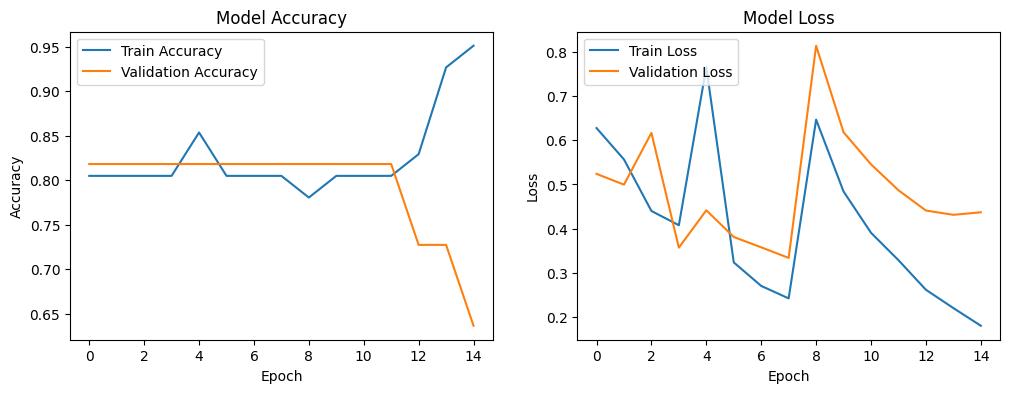

In [60]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

plt.show()

In [61]:
print("\nTraining Metrics:")
for key, values in history.history.items():
    print(f"{key}: {values}")

# Print final metrics after training
print("\nFinal Training Accuracy:", history.history['accuracy'][-1])
print("Final Validation Accuracy:", history.history['val_accuracy'][-1])
print("Final Training Loss:", history.history['loss'][-1])
print("Final Validation Loss:", history.history['val_loss'][-1])


Training Metrics:
loss: [0.6275472044944763, 0.5565288066864014, 0.44003501534461975, 0.4078109562397003, 0.7653383612632751, 0.32373449206352234, 0.2705725431442261, 0.24240612983703613, 0.6465162634849548, 0.483989953994751, 0.39071521162986755, 0.328737735748291, 0.26190850138664246, 0.22049440443515778, 0.18060064315795898]
accuracy: [0.8048780560493469, 0.8048780560493469, 0.8048780560493469, 0.8048780560493469, 0.8536585569381714, 0.8048780560493469, 0.8048780560493469, 0.8048780560493469, 0.7804877758026123, 0.8048780560493469, 0.8048780560493469, 0.8048780560493469, 0.8292682766914368, 0.9268292784690857, 0.9512194991111755]
val_loss: [0.5239207744598389, 0.49955958127975464, 0.6165515780448914, 0.35713207721710205, 0.44163474440574646, 0.3812115788459778, 0.35783231258392334, 0.3338778614997864, 0.813607394695282, 0.6179336905479431, 0.5454277992248535, 0.4868623912334442, 0.44098928570747375, 0.43134135007858276, 0.4370124936103821]
val_accuracy: [0.8181818127632141, 0.81818

In [ ]:
import os

def get_video_names(folder_path):
    video_names = set()
    for filename in os.listdir(folder_path):
        if filename.endswith(".jpg"):
            video_name = filename.rsplit('_', 2)[0]
            video_names.add(video_name)
    return video_names


folders = {
    "train_no_gun": 'train_all/no_gun',
    "train_gun_will_appear":'train_all/gun_will_appear',
    "test_no_gun": 'test_all/no_gun',
    "test_gun_will_appear":'test_all/gun_will_appear'
}

video_names = {folder: get_video_names(path) for folder, path in folders.items()}

for folder, names in video_names.items():
    print(f"{folder}:")
    for name in names:
        print(name)
    print()

In [ ]:
common_train = video_names["train_no_gun"].intersection(video_names["train_gun_will_appear"])
common_test = video_names["test_no_gun"].intersection(video_names["test_gun_will_appear"])
common_train_test = video_names["train_no_gun"].intersection(video_names["test_no_gun"])
common_gun_appear = video_names["train_gun_will_appear"].intersection(video_names["test_gun_will_appear"])

print("Common video names in train_no_gun and train_gun_will_appear:")
for name in common_train:
    print(name)

print("\nCommon video names in test_no_gun and test_gun_will_appear:")
for name in common_test:
    print(name)

print("\nCommon video names in train_no_gun and test_no_gun:")
for name in common_train_test:
    print(name)

print("\nCommon video names in train_gun_will_appear and test_gun_will_appear:")
for name in common_gun_appear:
    print(name)

In [38]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, TimeDistributed, LSTM, Dense
from tensorflow.keras.optimizers import Adam

def create_model(sequence_length, img_size=(64, 64, 3)):
    model = Sequential()
    model.add(TimeDistributed(Conv2D(16, (3, 3), activation='relu'), input_shape=(sequence_length,) + img_size))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Conv2D(32, (3, 3), activation='relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Flatten()))
    model.add(LSTM(20, activation='relu'))
    model.add(Dense(len(categories), activation='softmax'))  # Adjust number of classes
    model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

model = create_model(max_sequence_length)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_5 (TimeDi  (None, 2282, 62, 62, 16   448       
 stributed)                  )                                   
                                                                 
 time_distributed_6 (TimeDi  (None, 2282, 31, 31, 16   0         
 stributed)                  )                                   
                                                                 
 time_distributed_7 (TimeDi  (None, 2282, 29, 29, 32   4640      
 stributed)                  )                                   
                                                                 
 time_distributed_8 (TimeDi  (None, 2282, 14, 14, 32   0         
 stributed)                  )                                   
                                                                 
 time_distributed_9 (TimeDi  (None, 2282, 6272)       

In [55]:
import tensorflow as tf

class CustomF1Score(tf.keras.metrics.Metric):
    def __init__(self, name='f1_score', **kwargs):
        super(CustomF1Score, self).__init__(name=name, **kwargs)
        self.tp = self.add_weight(name='tp', initializer='zeros')
        self.fp = self.add_weight(name='fp', initializer='zeros')
        self.fn = self.add_weight(name='fn', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.argmax(y_pred, axis=1)
        y_true = tf.argmax(y_true, axis=1)
        y_true = tf.cast(y_true, 'float32')
        y_pred = tf.cast(y_pred, 'float32')

        tp = tf.math.reduce_sum(tf.cast(y_true * y_pred, 'float32'))
        fp = tf.math.reduce_sum(tf.cast((1 - y_true) * y_pred, 'float32'))
        fn = tf.math.reduce_sum(tf.cast(y_true * (1 - y_pred), 'float32'))

        self.tp.assign_add(tp)
        self.fp.assign_add(fp)
        self.fn.assign_add(fn)

    def result(self):
        precision = self.tp / (self.tp + self.fp + tf.keras.backend.epsilon())
        recall = self.tp / (self.tp + self.fn + tf.keras.backend.epsilon())
        return 2 * ((precision * recall) / (precision + recall + tf.keras.backend.epsilon()))

    def reset_states(self):
        for var in self.variables:
            var.assign(0)

In [56]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.utils import to_categorical
from collections import defaultdict


class VideoFrameGenerator(tf.keras.utils.Sequence):
    def __init__(self, base_path, categories, img_size=(64, 64), batch_size=1, max_duration=5, frame_rate=24):
        self.base_path = base_path
        self.categories = categories
        self.img_size = img_size
        self.batch_size = batch_size
        self.data = []
        self.labels = []
        self.max_sequence_length = min(max_duration * frame_rate, max_sequence_length)

        for category in categories:
            path = os.path.join(base_path, category)
            class_num = categories.index(category)

            video_frames = defaultdict(list)
            for frame in sorted(os.listdir(path)):
                video_id = "_".join(frame.split('_')[:-1])
                video_frames[video_id].append(frame)

            for video_id, frames in video_frames.items():
                if len(frames) > self.max_sequence_length:
                    frames = frames[:self.max_sequence_length]
                self.data.append((category, frames))
                self.labels.append(class_num)
                self.max_sequence_length = max(self.max_sequence_length, len(frames))

        self.labels = to_categorical(self.labels, num_classes=len(categories))

    def __len__(self):
        return int(np.ceil(len(self.data) / self.batch_size))

    def __getitem__(self, idx):
        batch_data = self.data[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_labels = self.labels[idx * self.batch_size:(idx + 1) * self.batch_size]

        X_batch = []
        for category, frames in batch_data:
            video_data = []
            for frame in frames:
                img_path = os.path.join(self.base_path, category, frame)
                img = load_img(img_path, target_size=self.img_size)
                img_array = img_to_array(img)
                if np.isnan(img_array).any() or np.isinf(img_array).any():
                    raise ValueError("NaNs or Infs found in image data") # was giving an error
                img_array = img_array.astype('float32') / 255.0
                video_data.append(img_array)
            padded_video_data = tf.keras.preprocessing.sequence.pad_sequences(
                [video_data], maxlen=self.max_sequence_length, padding='post', dtype='float32')[0]
            X_batch.append(padded_video_data)

        return np.array(X_batch), np.array(batch_labels)

def compute_max_sequence_length(base_path, categories, max_duration=5, frame_rate=30):
    max_sequence_length = max_duration * frame_rate
    return max_sequence_length

max_sequence_length_train = compute_max_sequence_length(train_path, categories)
max_sequence_length_test = compute_max_sequence_length(test_path, categories)
max_sequence_length = max(max_sequence_length_train, max_sequence_length_test)

print("Maximum sequence length:", max_sequence_length)


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, TimeDistributed, LSTM, Dense
from tensorflow.keras.optimizers import Adam

def create_model(sequence_length, img_size=(64, 64, 3)):
    model = Sequential()
    model.add(TimeDistributed(Conv2D(16, (3, 3), activation='relu'), input_shape=(sequence_length,) + img_size))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Conv2D(32, (3, 3), activation='relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Flatten()))
    model.add(LSTM(20, activation='relu'))
    model.add(Dense(len(categories), activation='softmax'))
    model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

model = create_model(max_sequence_length)
model.summary()


train_generator = VideoFrameGenerator(train_path, categories, batch_size=1)
test_generator = VideoFrameGenerator(test_path, categories, batch_size=1)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=[CustomF1Score(), tf.keras.metrics.BinaryAccuracy()])

history = model.fit(train_generator, epochs=20, validation_data=test_generator, callbacks=[stepwise_metrics_callback])


model_save_path = 'baseline_model15'
model.save(model_save_path)
print(f"Model saved to {model_save_path}")

print("\nTraining Metrics:")
for key, values in history.history.items():
    print(f"{key}: {values}")

Maximum sequence length: 150
Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_45 (TimeD  (None, 150, 62, 62, 16)   448       
 istributed)                                                     
                                                                 
 time_distributed_46 (TimeD  (None, 150, 31, 31, 16)   0         
 istributed)                                                     
                                                                 
 time_distributed_47 (TimeD  (None, 150, 29, 29, 32)   4640      
 istributed)                                                     
                                                                 
 time_distributed_48 (TimeD  (None, 150, 14, 14, 32)   0         
 istributed)                                                     
                                                                 
 time_distributed_49 (Tim